In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tabulate import tabulate


import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('marriage_divorce_india_with_id.csv')
df = data.copy()
df.head()

,Unique ID,Marriage Duration (Years),Age at Marriage,Marriage Type,Education Level,Income Level (INR per month),Caste/Religion,Urban/Rural,Family Involvement,Children,Divorce Status
0,MD1,39,29,Love,Secondary,113464,Hindu,Rural,Moderate,2,No
1,MD2,29,34,Arranged,No Education,18682,Jain,Rural,Moderate,0,Yes
2,MD3,15,34,Love,No Education,159455,Muslim,Urban,Moderate,4,Yes
3,MD4,8,27,Arranged,Postgraduate,63160,Jain,Urban,High,1,Yes
4,MD5,21,34,Love,Secondary,28666,Jain,Urban,High,1,Yes


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unique ID                     1200 non-null   object
 1   Marriage Duration (Years)     1200 non-null   int64 
 2   Age at Marriage               1200 non-null   int64 
 3   Marriage Type                 1200 non-null   object
 4   Education Level               1200 non-null   object
 5   Income Level (INR per month)  1200 non-null   int64 
 6   Caste/Religion                1200 non-null   object
 7   Urban/Rural                   1200 non-null   object
 8   Family Involvement            1200 non-null   object
 9   Children                      1200 non-null   int64 
 10  Divorce Status                1200 non-null   object
dtypes: int64(4), object(7)
memory usage: 103.3+ KB


In [10]:
df.shape

(1200, 11)

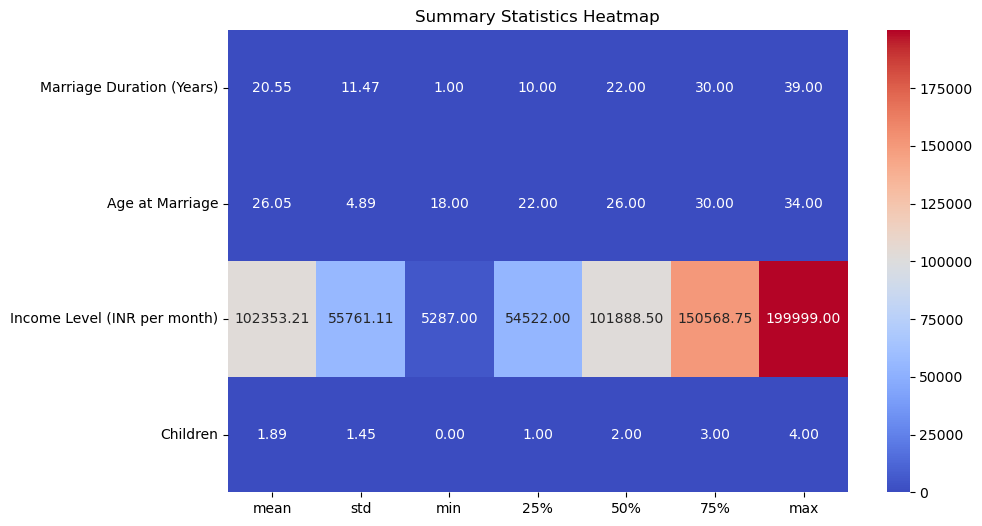

In [12]:
desc = df.describe().T
plt.figure(figsize=(10, 6))
sns.heatmap(desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Summary Statistics Heatmap')
plt.show()

In [14]:
df.isnull().sum()

Unique ID                       0
Marriage Duration (Years)       0
Age at Marriage                 0
Marriage Type                   0
Education Level                 0
Income Level (INR per month)    0
Caste/Religion                  0
Urban/Rural                     0
Family Involvement              0
Children                        0
Divorce Status                  0
dtype: int64

In [16]:
missing_percentage = df.isnull().mean() * 100

missing_table = pd.DataFrame({
    'Missing Data Percentage (%)': missing_percentage
}).reset_index().rename(columns={'index': 'Column'})

print(tabulate(missing_table, headers='keys', tablefmt='grid', showindex=False))

+------------------------------+-------------------------------+
| Column                       |   Missing Data Percentage (%) |
+==============================+===============================+
| Unique ID                    |                             0 |
+------------------------------+-------------------------------+
| Marriage Duration (Years)    |                             0 |
+------------------------------+-------------------------------+
| Age at Marriage              |                             0 |
+------------------------------+-------------------------------+
| Marriage Type                |                             0 |
+------------------------------+-------------------------------+
| Education Level              |                             0 |
+------------------------------+-------------------------------+
| Income Level (INR per month) |                             0 |
+------------------------------+-------------------------------+
| Caste/Religion         

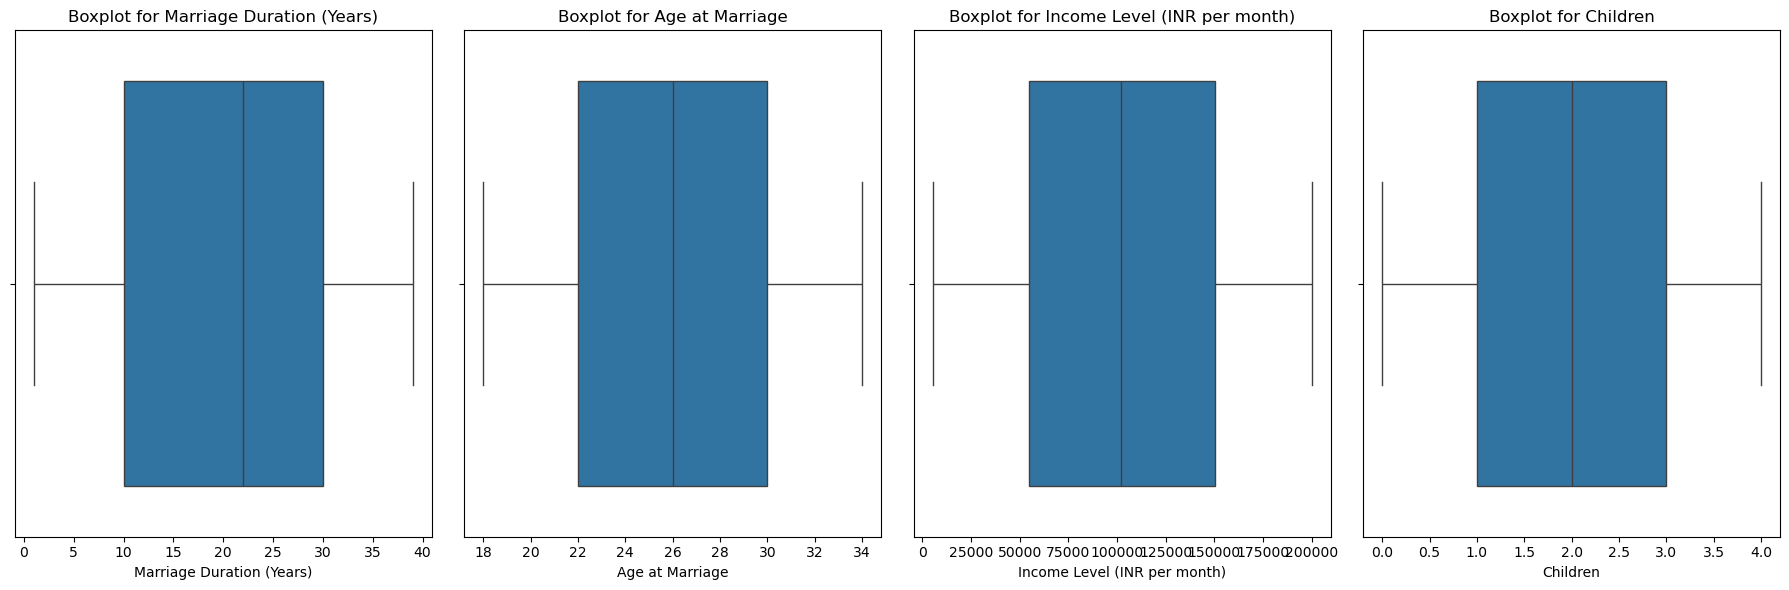

In [18]:
def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_columns = len(numeric_columns)
    num_per_row = 4 
    num_rows = -(-num_columns // num_per_row)  

    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(18, 6 * num_rows))
    axes = axes.flatten()
    
    for i, column in enumerate(numeric_columns):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        sns.boxplot(x=df[column], ax=axes[i])
        axes[i].set_title(f'Boxplot for {column}')
    
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return df

df = remove_outliers(df)

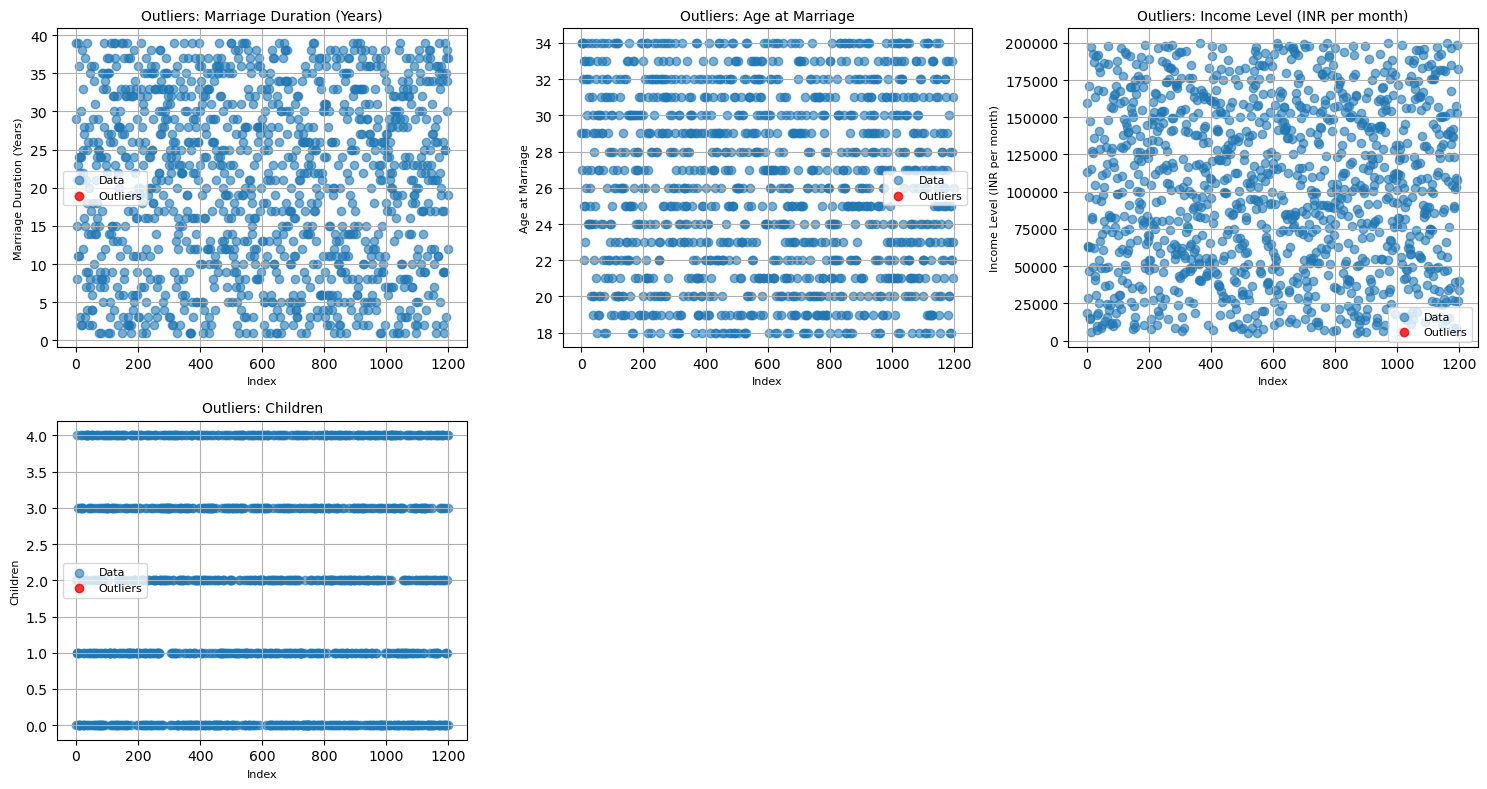

In [20]:
def plot_outliers_iqr(data):

    numeric_columns = data.select_dtypes(include=[np.number]).columns
    threshold = 1.5
    n_cols = 3 
    n_rows = -(-len(numeric_columns) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), squeeze=False)
    axes = axes.flatten() 
    
    for idx, column in enumerate(numeric_columns):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = (data[column] < lower_bound) | (data[column] > upper_bound)

        axes[idx].scatter(data.index, data[column], label='Data', alpha=0.6)
        axes[idx].scatter(data.index[outliers], data[column][outliers], color='red', label='Outliers', alpha=0.8)
        axes[idx].set_title(f"Outliers: {column}", fontsize=10)
        axes[idx].set_xlabel("Index", fontsize=8)
        axes[idx].set_ylabel(column, fontsize=8)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True)
        
    for ax in axes[len(numeric_columns):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_outliers_iqr(df)

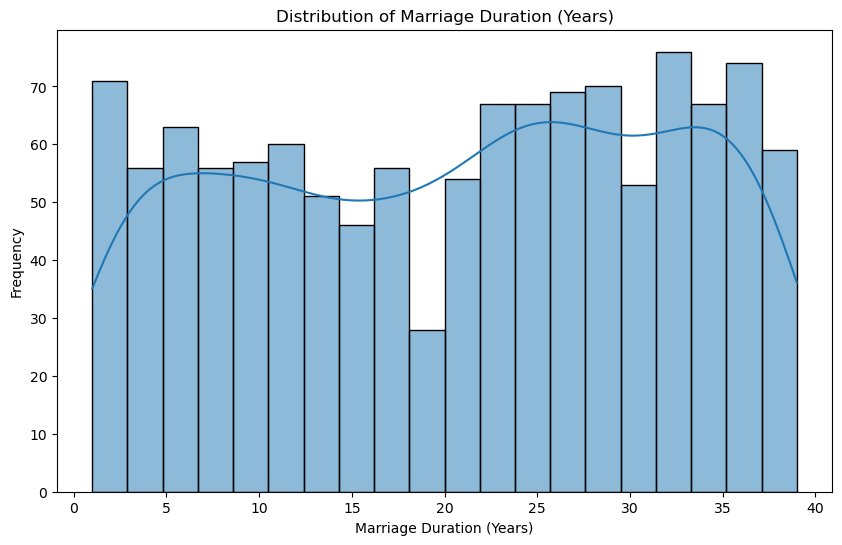

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Marriage Duration (Years)'], kde=True, bins=20)
plt.title('Distribution of Marriage Duration (Years)')
plt.xlabel('Marriage Duration (Years)')
plt.ylabel('Frequency')
plt.show()

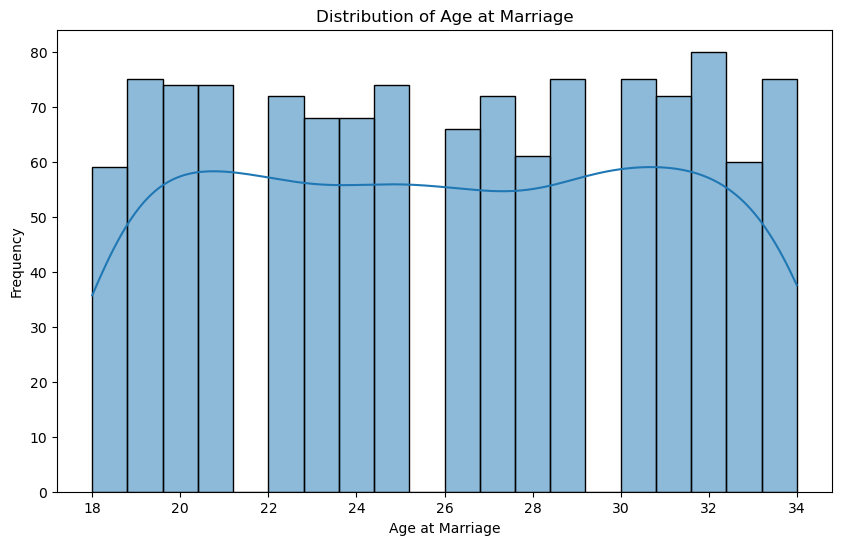

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age at Marriage'], kde=True, bins=20)
plt.title('Distribution of Age at Marriage')
plt.xlabel('Age at Marriage')
plt.ylabel('Frequency')
plt.show()


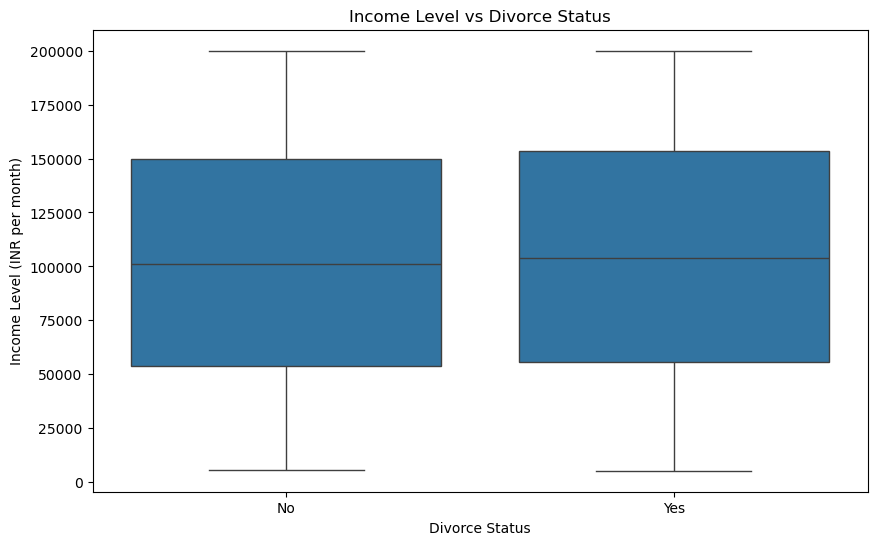

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Divorce Status', y='Income Level (INR per month)', data=df)
plt.title('Income Level vs Divorce Status')
plt.xlabel('Divorce Status')
plt.ylabel('Income Level (INR per month)')
plt.show()


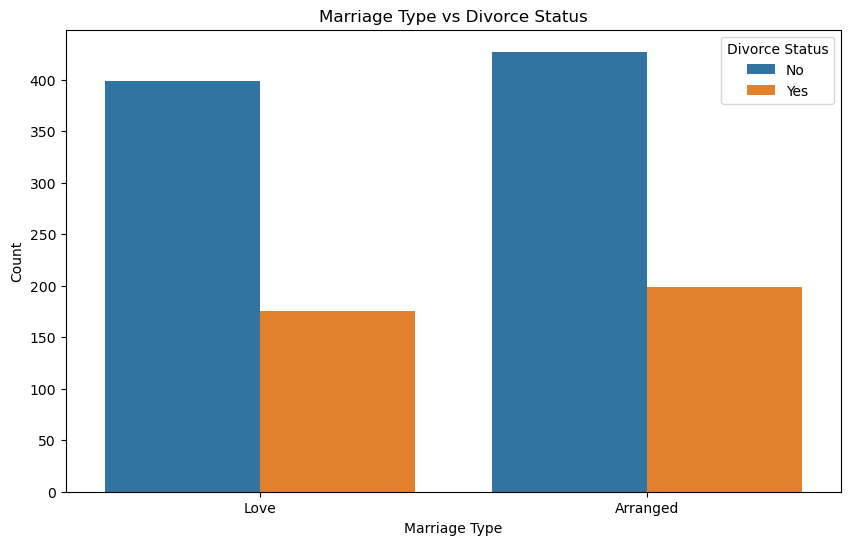

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Marriage Type', hue='Divorce Status', data=df)
plt.title('Marriage Type vs Divorce Status')
plt.xlabel('Marriage Type')
plt.ylabel('Count')
plt.show()

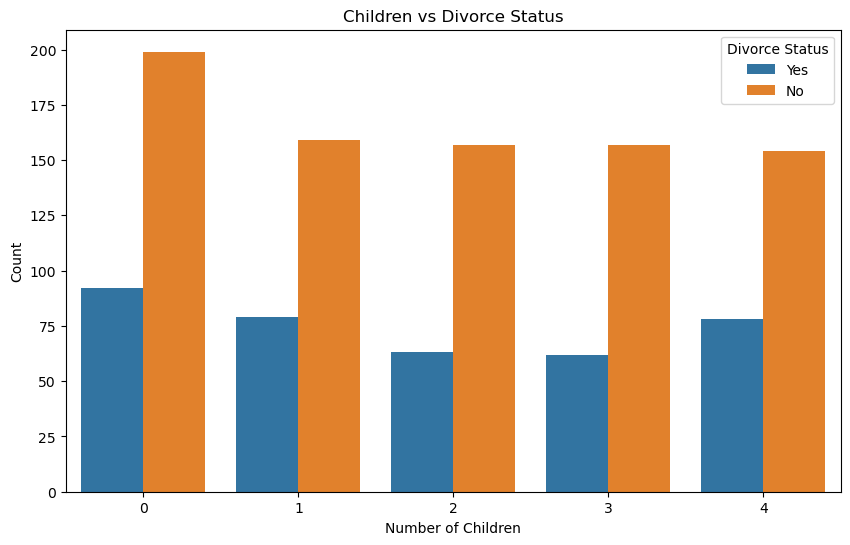

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Children', hue='Divorce Status', data=df)
plt.title('Children vs Divorce Status')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

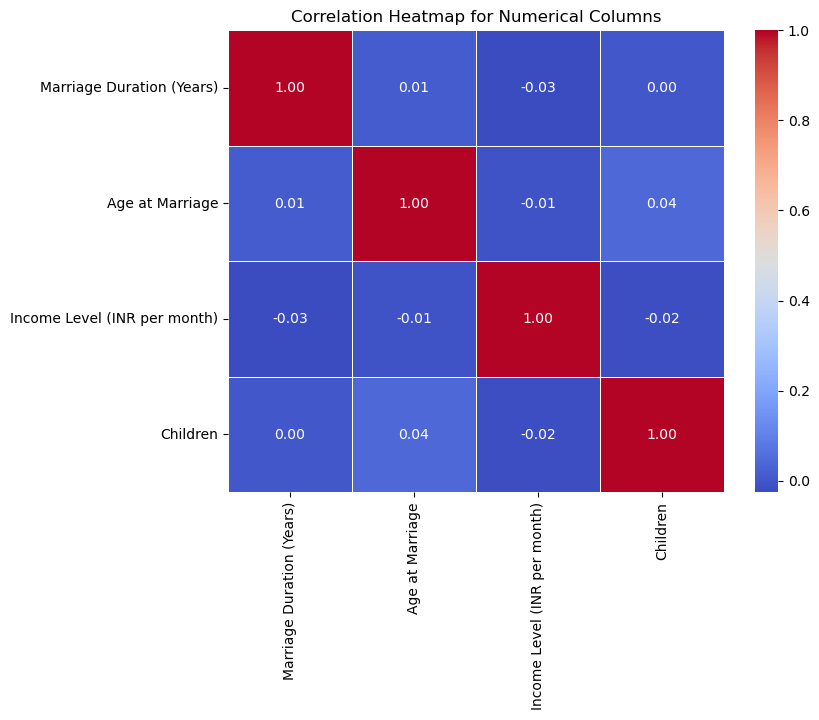

In [40]:
corr = df[['Marriage Duration (Years)', 'Age at Marriage', 'Income Level (INR per month)', 'Children']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for Numerical Columns')
plt.show()

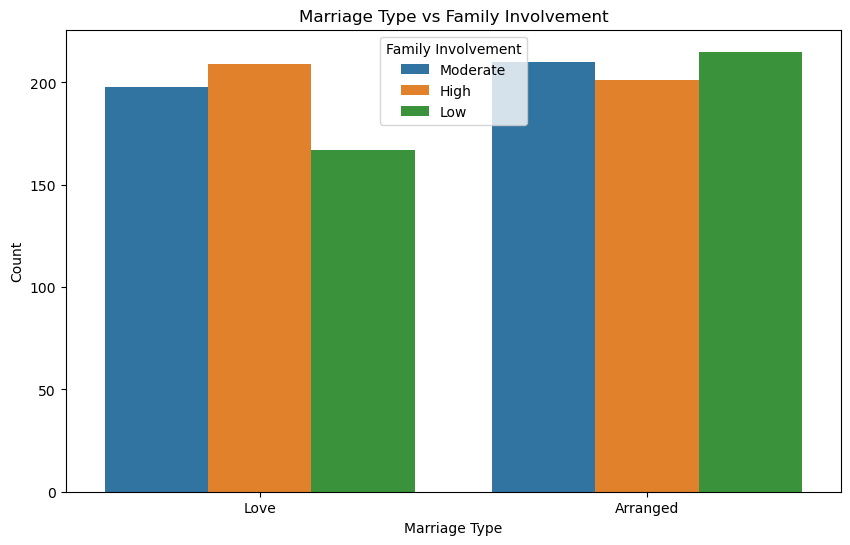

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Marriage Type', hue='Family Involvement', data=df)
plt.title('Marriage Type vs Family Involvement')
plt.xlabel('Marriage Type')
plt.ylabel('Count')
plt.show()


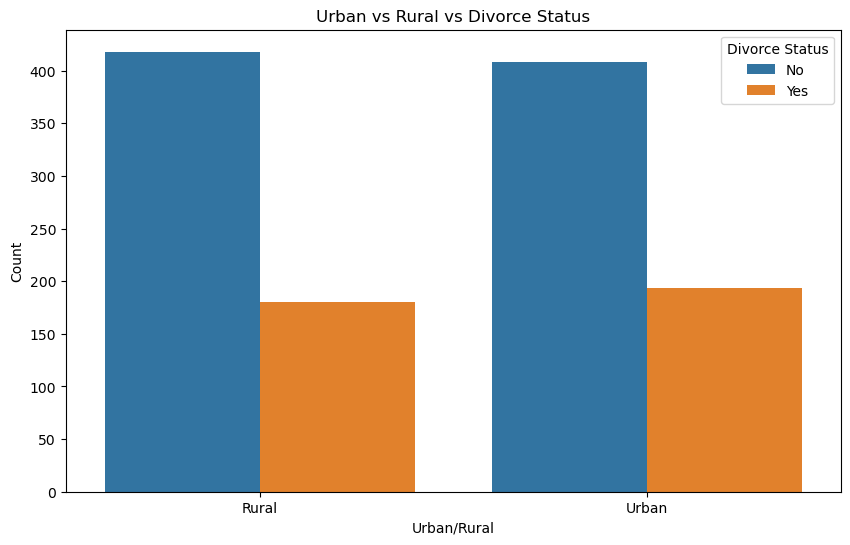

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Urban/Rural', hue='Divorce Status', data=df)
plt.title('Urban vs Rural vs Divorce Status')
plt.xlabel('Urban/Rural')
plt.ylabel('Count')
plt.show()

In [52]:
df = df.drop(columns=['Unique ID'])

In [54]:
encoder = LabelEncoder()

label_mappings = {}

for col in df.select_dtypes('object'):
    df[col] = encoder.fit_transform(df[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

for col, mapping in label_mappings.items():
    print(f"Column: {col}")
    for label, code in mapping.items():
        print(f"{code} -> {label}")
    print()

Column: Marriage Type
0 -> Arranged
1 -> Love

Column: Education Level
0 -> Graduate
1 -> No Education
2 -> Postgraduate
3 -> Primary
4 -> Secondary

Column: Caste/Religion
0 -> Christian
1 -> Hindu
2 -> Jain
3 -> Muslim
4 -> Other
5 -> Sikh

Column: Urban/Rural
0 -> Rural
1 -> Urban

Column: Family Involvement
0 -> High
1 -> Low
2 -> Moderate

Column: Divorce Status
0 -> No
1 -> Yes



In [56]:
from sklearn.model_selection import train_test_split

X = df.drop('Divorce Status',axis = 1)
y = df['Divorce Status']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(960, 9) (240, 9)


In [60]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
knn_accuracy

0.6541666666666667

In [62]:
loj = LogisticRegression(solver = 'liblinear')
loj_model = loj.fit(X, y)
y_pred = loj_model.predict(X)
lr_accuracy = accuracy_score(y, y_pred)
lr_accuracy

0.6883333333333334

In [64]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_accuracy

0.7083333333333334

In [66]:
xgb_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.625

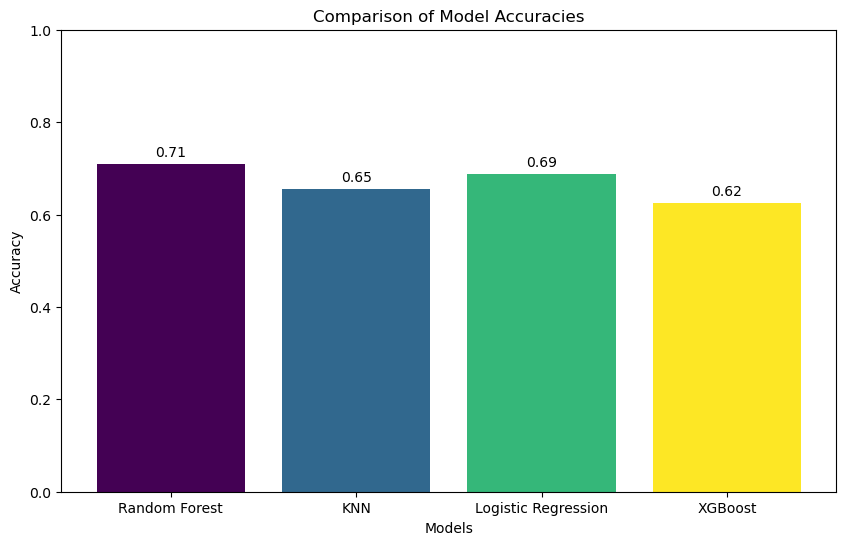

In [68]:
models = ['Random Forest', 'KNN', 'Logistic Regression', 'XGBoost']
accuracies = [rf_accuracy, knn_accuracy, lr_accuracy, xgb_accuracy]

colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
